<a href="https://colab.research.google.com/github/sivashiri/draft/blob/main/Payzone_precitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Generation of data: porosity, permeability, saturation, net pay thickness in csv file**

In [75]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_samples = 500

# Generate synthetic input data
porosity = np.random.uniform(5, 25, n_samples)
water_saturation = np.random.uniform(20, 80, n_samples)
permeability = np.random.uniform(10, 1000, n_samples)
net_pay_thickness = np.random.uniform(0, 50, n_samples)

# Define payzone: if porosity is high, Sw is low, perm is high, and thickness is decent
payzone = (
    (porosity > 12) &
    (water_saturation < 45) &
    (permeability > 150) &
    (net_pay_thickness > 10)
).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'porosity': porosity,
    'water_saturation': water_saturation,
    'permeability': permeability,
    'net_pay_thickness': net_pay_thickness,
    'payzone': payzone
})

# Save to CSV
df.to_csv('synthetic_payzone_data.csv', index=False)
print("✅ Dataset saved as synthetic_payzone_data.csv")


✅ Dataset saved as synthetic_payzone_data.csv


## **Training of the ML model: MLP Classifier Model**

Accuracy: 0.952

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       102
           1       0.95      0.78      0.86        23

    accuracy                           0.95       125
   macro avg       0.95      0.89      0.91       125
weighted avg       0.95      0.95      0.95       125



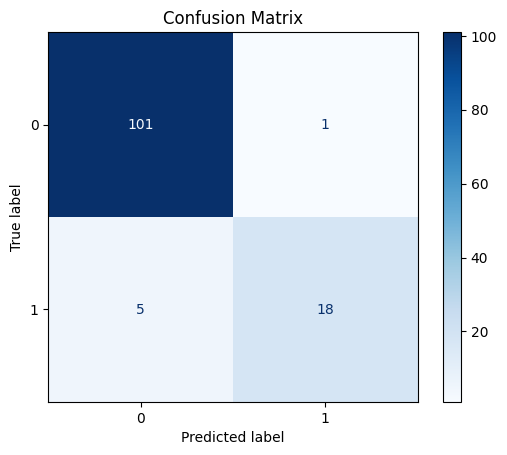

✅ MLP model and scaler saved.


In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Load data
df = pd.read_csv('synthetic_payzone_data.csv')
df.dropna(inplace=True)  # Remove missing rows if any

# Define features and target
X = df[['porosity', 'water_saturation', 'permeability', 'net_pay_thickness']]
y = df['payzone']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Train MLP
model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Save model
with open('payzone_mlp_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ MLP model and scaler saved.")


## **Validation using cross validation**



In [77]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation accuracy scores:", scores)
print("Average CV accuracy:", scores.mean())


Cross-validation accuracy scores: [0.89 0.88 0.93 0.91 0.95]
Average CV accuracy: 0.9120000000000001


## **Validation of the model with external unseen data**

In [78]:
new_sample = [[18, 24, 170,11]]  # porosity, Sw, perm, net pay
manual_scaled = scaler.transform(new_sample)
prediction = model.predict(manual_scaled)
#prediction = model.predict(new_sample)
print("Prediction (1 = payzone):", prediction)

Prediction (1 = payzone): [0]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## **Building of the streamlit app**

In [80]:
pip install streamlit

In [83]:
%%writefile /content/app.py
import streamlit as st
import pickle
import numpy as np
import streamlit as st
import sklearn


# Load trained model
with open('payzone_mlp_model.pkl', 'rb') as f:
    model = pickle.load(f)

# App title
st.title("🏞️ Payzone Prediction App")
st.write("Enter reservoir properties to predict if it's a potential **oil/gas payzone**.")

# Input fields
porosity = st.number_input("Porosity (percentage, e.g. 15)", min_value=0.0, max_value=100.0, step=0.01)
water_saturation = st.number_input("Water Saturation (percentage, e.g. 25)", min_value=0.0, max_value=100.0, step=0.01)
permeability = st.number_input("Permeability (mD)", min_value=0.0, step=1.0)
net_pay_thickness = st.number_input("Net Pay Thickness (m)", min_value=0.0, step=0.1)

# Predict button
if st.button("Predict"):
    # Prepare input
    input_data = np.array([[porosity, water_saturation, permeability, net_pay_thickness]])
    scaled_input = scaler.transform(input_data)
    # Make prediction
    prediction = model.predict(scaled_input)[0]

    # Show result
    if prediction == 1:
        st.success("✅ This zone is likely a **Payzone**.")
    else:
        st.warning("⚠️ This zone is likely **Not a Payzone**.")


Overwriting /content/app.py


In [84]:
%%writefile requirements.txt
streamlit
scikit-learn
numpy
pandas


Overwriting requirements.txt
